# Spaceship Titanic

Predict which passengers are transported to an alternate dimension

Link to the contest: https://www.kaggle.com/competitions/spaceship-titanic

Rank: 420

Score: 0.80032




## Downloading the Data

In [ ]:
# Using collab and pasted the kaggle.json in the content file

import os

# Create the directory
os.makedirs('/root/.config/kaggle/', exist_ok=True)

# Copy the kaggle.json file to the directory (updated path)
!cp /content/kaggle.json /root/.config/kaggle/


!chmod 600 /root/.config/kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 75.8MB/s]


In [ ]:
! unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Loading data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from numpy import log1p as log

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ds = train.copy()
test_ds = test.copy()

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(8693, 14)
(4277, 13)


In [ ]:
train_ds.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [ ]:
test_ds.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Analyzing the features
1. Will be dropping passenger id, and name.
2. HomePlanet, CryoSleep, Destination, VIP are simple categorical.
3. Will extract the first alphabet of Cabin to make it categorical.
4. Age can be binned into categorical groups.
5. Will analyze the expense related columns separately and altogether with the survival to find any correlation.


## EDA and Data Processing

In [ ]:
missing_values = train_ds.isnull().sum().sort_values(ascending=False)
missing_values

,0
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Name,200
Cabin,199
VRDeck,188
FoodCourt,183
Spa,183
Destination,182


Missing data doesn't seem significant to the overall size of the data. Will be changing with median for numerical data and mode for categorical data.

In [ ]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
columns_to_drop = ['PassengerId', 'Name']
train_ds = train_ds.drop(columns=columns_to_drop)
test_ds = test_ds.drop(columns=columns_to_drop)

In [ ]:
train_ds.Cabin = train_ds.Cabin.str[0]
test_ds.Cabin = test_ds.Cabin.str[0]

In [ ]:
train_ds.Age =  train_ds.Age//10
test_ds.Age = test_ds.Age//10

In [ ]:
train_ds['TotalExpenditure'] = train_ds[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_ds['TotalExpenditure'] = test_ds[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)


In [ ]:
numeric_ds = train_ds.select_dtypes(include=['int64', 'float64'])
numeric_ds['Transported'] = train_ds.Transported.astype(int)
numeric_ds.head()




,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenditure,Transported
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2.0,109.0,9.0,25.0,549.0,44.0,736.0,1
2,5.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,0
3,3.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,0
4,1.0,303.0,70.0,151.0,565.0,2.0,1091.0,1


Transported         1.000000
FoodCourt           0.046566
ShoppingMall        0.010141
Age                -0.073075
TotalExpenditure   -0.199514
VRDeck             -0.207075
Spa                -0.221131
RoomService        -0.244611
Name: Transported, dtype: float64


<Axes: xlabel='None', ylabel='Transported'>

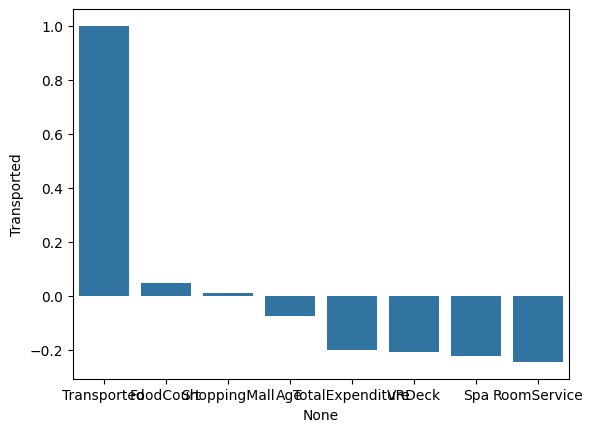

In [ ]:
corr_target = numeric_ds.corr()['Transported'].sort_values(ascending=False)
print(corr_target)
sns.barplot(x=corr_target.index, y=corr_target)


<Axes: >

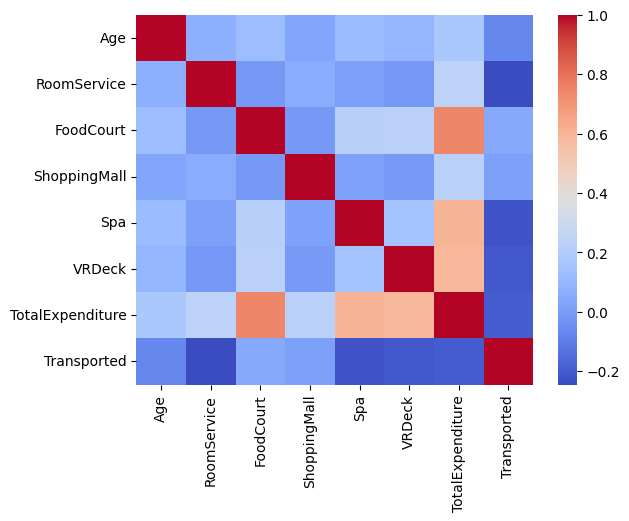

In [ ]:
sns.heatmap(numeric_ds.corr(),cmap='coolwarm')

In [ ]:
numeric_ds.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenditure,Transported
Age,1.000000,0.067567,0.123677,0.031131,0.118519,0.094294,0.177100,-0.073075
RoomService,0.067567,1.000000,-0.015889,0.054480,0.010080,-0.019581,0.237998,-0.244611
FoodCourt,0.123677,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.745105,0.046566
ShoppingMall,0.031131,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.222310,0.010141
Spa,0.118519,0.010080,0.221891,0.013879,1.000000,0.153821,0.596633,-0.221131
VRDeck,0.094294,-0.019581,0.227995,-0.007322,0.153821,1.000000,0.586299,-0.207075
TotalExpenditure,0.177100,0.237998,0.745105,0.222310,0.596633,0.586299,1.000000,-0.199514
Transported,-0.073075,-0.244611,0.046566,0.010141,-0.221131,-0.207075,-0.199514,1.000000


From the above analysis
1. Dropping Shopping Mall and including Total Expenditure as a feature.
2. Total expenditure looks slightly skewed, using log of total expenditure.


In [ ]:
train_ds.drop('ShoppingMall', axis=1, inplace=True)
test_ds.drop('ShoppingMall', axis = 1, inplace=True)

In [ ]:
# Summing essential and non-essential services separately
train_ds['EssentialSpend'] = train_ds['RoomService'] + train_ds['FoodCourt']
test_ds['EssentialSpend'] = test_ds['RoomService'] + test_ds['FoodCourt']
train_ds['LuxurySpend'] = train['ShoppingMall'] + train_ds['Spa'] + train_ds['VRDeck']
test_ds['LuxurySpend'] = test['ShoppingMall'] + test_ds['Spa'] + test_ds['VRDeck']


Converting features to numerical form.

In [ ]:
for i in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP','Transported','Age']:
  train_ds[i] = train_ds[i].astype('category')
  train_ds[i] = train_ds[i].cat.codes
  train_ds[i].fillna(train_ds[i].mode()[0], inplace=True)
  if i!= 'Transported':
    test_ds[i] = test_ds[i].astype('category')
    test_ds[i] = test_ds[i].cat.codes
    test_ds[i].fillna(test_ds[i].mode()[0], inplace=True)

In [ ]:
train_ds

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,Spa,VRDeck,Transported,TotalExpenditure,EssentialSpend,LuxurySpend
0,1,0,1,2,3,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0,0,5,2,2,0,109.0,9.0,549.0,44.0,1,736.0,118.0,618.0
2,1,0,0,2,5,1,43.0,3576.0,6715.0,49.0,0,10383.0,3619.0,6764.0
3,1,0,0,2,3,0,0.0,1283.0,3329.0,193.0,0,5176.0,1283.0,3893.0
4,0,0,5,2,1,0,303.0,70.0,565.0,2.0,1,1091.0,373.0,718.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0,4,1,0.0,6819.0,1643.0,74.0,0,8536.0,6819.0,1717.0
8689,0,1,6,1,1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
8690,0,0,6,2,2,0,0.0,0.0,1.0,0.0,1,1873.0,0.0,1873.0
8691,1,0,4,0,3,0,0.0,1049.0,353.0,3235.0,0,4637.0,1049.0,3588.0


Min Max scaling for Expense related features

In [ ]:
for i in ['RoomService', 'FoodCourt', 'Spa', 'VRDeck','TotalExpenditure','EssentialSpend','LuxurySpend']:
  train_ds[i] = (train_ds[i] - train_ds[i].min()) / (train_ds[i].max() - train_ds[i].min())
  test_ds[i] = (test_ds[i] - test_ds[i].min()) / (test_ds[i].max() - test_ds[i].min())
  train_ds[i].fillna(train_ds[i].median(), inplace=True)
  test_ds[i].fillna(test_ds[i].median(), inplace=True)

In [ ]:
xTrain = train_ds.drop('Transported', axis=1)
yTrain = train_ds.Transported

In [ ]:
yTrain

,Transported
0,0
1,1
2,0
3,0
4,1
...,...
8688,0
8689,0
8690,1
8691,0


In [ ]:
xTrain,xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

## Model Training

In [ ]:
model_Linear = LogisticRegression()
model_Linear.fit(xTrain, yTrain)

LogisticRegression()

In [ ]:
y_pred = model_Linear.predict(xValid)
model_Linear.score(xValid, yValid)

0.7446808510638298

In [ ]:
result = model_Linear.predict(test_ds).astype(bool)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(xTrain, yTrain)
y_pred_rf = model_rf.predict(xValid)
rf_accuracy = model_rf.score(xValid, yValid)
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.7797584818861415


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_gb.fit(xTrain, yTrain)
y_pred_gb = model_gb.predict(xValid)
gb_accuracy = model_gb.score(xValid, yValid)
print("Gradient Boosting Accuracy:", gb_accuracy)


Gradient Boosting Accuracy: 0.7849338700402531


In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(xTrain, yTrain)
y_pred_xgb = model_xgb.predict(xValid)
xgb_accuracy = model_xgb.score(xValid, yValid)
print("XGBoost Accuracy:", xgb_accuracy)


XGBoost Accuracy: 0.7901092581943646


In [ ]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_lgb.fit(xTrain, yTrain)
y_pred_lgb = model_lgb.predict(xValid)
lgb_accuracy = model_lgb.score(xValid, yValid)
print("LightGBM Accuracy:", lgb_accuracy)


[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
LightGBM Accuracy: 0.78953421506613


Best results are from xg boost classifier. Lets use Grid search for optimizing the approach.


In [63]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define parameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 30, 50]
}

# Initialize LightGBM with GridSearchCV
grid_lgb = GridSearchCV(LGBMClassifier(random_state=42), param_grid=lgb_param_grid, cv=3, scoring='accuracy', verbose=0)
grid_lgb.fit(xTrain, yTrain)

# Get best LightGBM model
best_lgb = grid_lgb.best_estimator_
print("Best LightGBM Model:", grid_lgb.best_params_)
print("Best LightGBM Accuracy:", grid_lgb.best_score_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize XGBoost with GridSearchCV
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                        param_grid=xgb_param_grid, cv=3, scoring='accuracy', verbose=0)
grid_xgb.fit(xTrain, yTrain)

# Get best XGBoost model
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Model:", grid_xgb.best_params_)
print("Best XGBoost Accuracy:", grid_xgb.best_score_)


Best XGBoost Model: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Best XGBoost Accuracy: 0.8039976991659477


In [58]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier


# Define base models
base_estimators = [
    ('LightGBM', model_lgb),
    ('XGBoost', best_xgb),
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Set up stacking ensemble
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_model, cv=5)
stacking_model.fit(xTrain, yTrain)

# Evaluate Stacking Model
stacking_accuracy = stacking_model.score(xValid, yValid)
print("Stacking Model Accuracy:", stacking_accuracy)



[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Info] Number of positive: 2800, number of negative: 2763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 13
[LightGBM] [Info] [binary:

## Submission

In [64]:
result = best_lgb.predict(test_ds).astype(bool)

In [65]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],  # Replace with appropriate identifier
    'Transported': result # Replace with the predictions from the best model
})
submission.to_csv('submission.csv', index=False)


In [66]:
result

array([ True, False,  True, ...,  True,  True,  True])

In [67]:
!kaggle competitions submit -c spaceship-titanic -f submission.csv -m "Message"

100% 56.0k/56.0k [00:00<00:00, 214kB/s]
Successfully submitted to Spaceship Titanic